In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
#From Jovian
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# !pip install split_folders

In [3]:
# import splitfolders
# input_folder = '/content/drive/MyDrive/Datasets/data'
# output_folder = "Splitted_Dataset"
# splitfolders.ratio(input_folder, output_folder, ratio=(.8, .2))

In [4]:
data_dir = "../Splitted_Dataset"

In [5]:
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms  = tt.Compose(
    [
        # tt.Grayscale(num_output_channels=1),
        tt.Resize((128,128)),
        # tt.RandomCrop(128, padding=4, padding_mode='reflect'), 
        tt.RandomHorizontalFlip(), 
        tt.RandomRotation(degrees=45),
        # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
        # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        tt.ToTensor(), 
        # tt.Normalize(*stats,inplace=True)
    ]
)

valid_tfms = tt.Compose(
    [
        # tt.Grayscale(num_output_channels=1),
        tt.Resize((128,128)),
        # tt.CenterCrop(128),
        tt.ToTensor(), 
        # tt.Normalize(*stats)
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir +"/train", train_tfms)
valid_ds = ImageFolder(data_dir +"/val", valid_tfms)

# set the batch size
batch_size = 26

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

def show_example(data):
    img, label = data
    print(classes[label])
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    # plt.imshow(img)

In [6]:
type(train_ds[0][0])

torch.Tensor

image.shape: torch.Size([3, 128, 128])
Label: Magnolia_Salicifolia


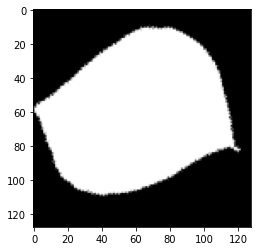

In [7]:
image, label = train_ds[500]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', classes[label])

Acer_Saccharinum


torch.Size([3, 128, 128])

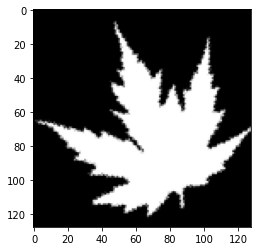

In [8]:
image_number = 120
show_example(train_ds[image_number])
train_ds[image_number][0].shape

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(28, 28))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:12], nrow=6).permute(1, 2, 0))
        break

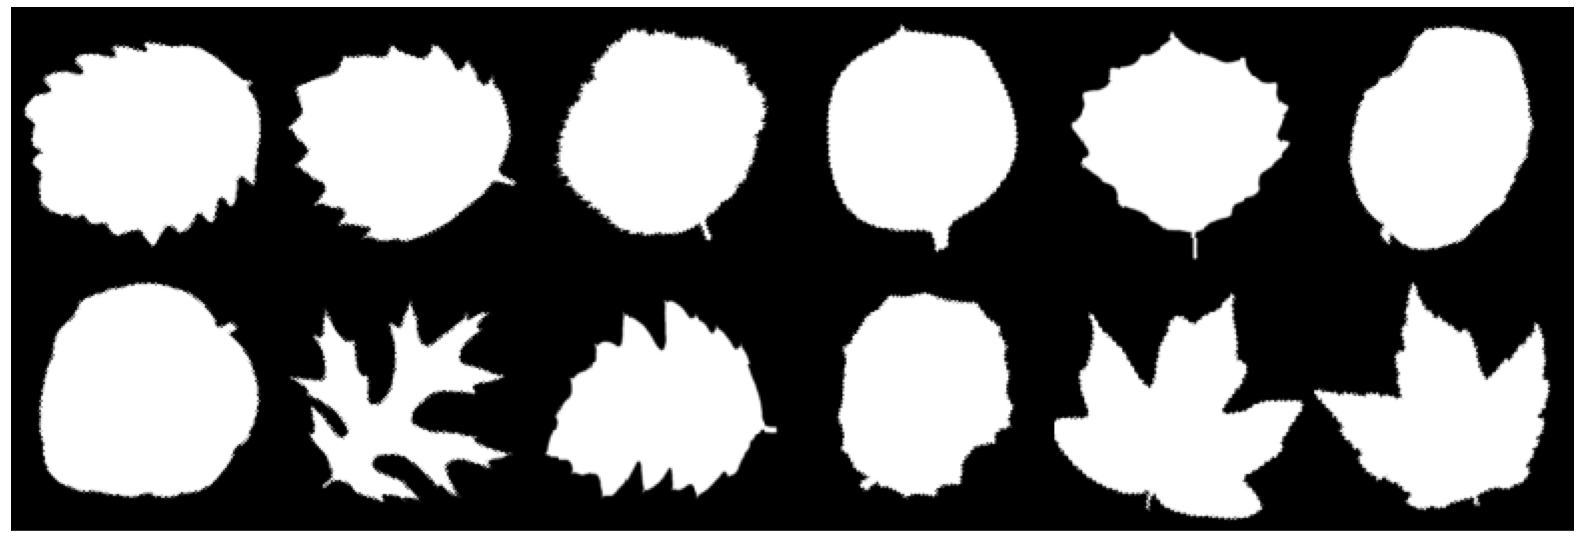

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
nn.BatchNorm2d(64)

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    print(nn.Sequential(*layers))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #Input 
        #3 x 150 x 150
        self.conv1 = conv_block(in_channels, 256) #64 x 150 x 150
        self.conv2 = conv_block(256, 512, pool=True) #128 X 150 x 150
        self.res1 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #128 x 150 x 150
        
        self.conv3 = conv_block(512, 1024, pool=True) #256  x 75 x 75
        self.conv4 = conv_block(1024, 2048, pool=True) #512 x 37 x 37
        self.res2 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048)) #512 x 37 x 37 
        
        self.classifier = nn.Sequential(nn.MaxPool2d(16), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(2048, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet9(3, 100), device)
model

Sequential(
  (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(1

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    # print(model.eval())
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#     optimizer = opt_func(model.parameters(), max_lr, betas=(0.9, 0.999), eps=1e-08)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

KeyboardInterrupt: 

In [ ]:
epochs = 60
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00002, train_loss: 6.0010, val_loss: 5.2872, val_acc: 0.0096
Epoch [1], last_lr: 0.00003, train_loss: 4.9583, val_loss: 3.7468, val_acc: 0.1749
Epoch [2], last_lr: 0.00005, train_loss: 4.6989, val_loss: 3.4838, val_acc: 0.2294
Epoch [3], last_lr: 0.00008, train_loss: 4.3620, val_loss: 3.2677, val_acc: 0.2009
Epoch [4], last_lr: 0.00011, train_loss: 4.3648, val_loss: 3.2845, val_acc: 0.2399
Epoch [5], last_lr: 0.00014, train_loss: 4.1722, val_loss: 3.1174, val_acc: 0.2732
Epoch [6], last_lr: 0.00018, train_loss: 4.2587, val_loss: 2.9898, val_acc: 0.2949
Epoch [7], last_lr: 0.00022, train_loss: 4.0986, val_loss: 3.2105, val_acc: 0.2228
Epoch [8], last_lr: 0.00026, train_loss: 4.0830, val_loss: 3.2774, val_acc: 0.1838
Epoch [9], last_lr: 0.00030, train_loss: 4.0073, val_loss: 3.4967, val_acc: 0.2174
Epoch [10], last_lr: 0.00034, train_loss: 3.8925, val_loss: 3.1598, val_acc: 0.2313
Epoch [11], last_lr: 0.00038, train_loss: 3.9595, val_loss: 3.3258, val_acc: 0.2863
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

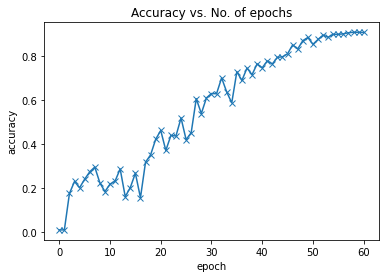

In [ ]:
plot_accuracies(history)

In [ ]:
torch.save(model.state_dict(), 'Medicinal_leaves_resnet9.pth')

In [22]:
model2 = to_device(ResNet9(3, 100), device)

Sequential(
  (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(1

In [23]:
model2.load_state_dict(torch.load('Medicinal_leaves_resnet9.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
model2

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [179]:
# evaluate(model2, valid_dl)

In [178]:
import matplotlib.image as mpimg

In [242]:
def test_image_preprocessing(test_img_path):
#     img = image.load_img(test_img_path, target_size=(224, 224))
#     im = Image.open(test_img_path)
    img = cv2.imread(test_img_path)
#     img = cv2.resize(cv2.imread(test_img_path, -1),(128,128))
#     img = cv2.resize(im,(128,128))
    # img = resize_img(img)
    # plt.imshow(img)
    # req = urlopen(test_img_path)
    # arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    # img = cv2.imdecode(arr, -1)
    # img = cv2.resize(img,(224, 224))

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])

    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result_img = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    # plt.imshow(mask)
    # img = image.load_img(test_img_path, target_size=(224, 224))
    # x = image.img_to_array(mask)
    # res = np.expand_dims(x, axis=0)
    # middle_img = [res]
    # return np.vstack(middle_img)
    return mask
    # return img

In [243]:
def predict_image(img, model):
    # Convert to a batch of 1
    # img = test_image_preprocessing(img)
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print(preds)
    return yb

In [244]:
# Create datasets
# test_ds = ImageFolder("/content/drive/MyDrive/Datasets/Test Images", train_tfms)
# valid_ds = ImageFolder(data_dir +"/val", valid_tfms)

In [245]:
# img, label = test_ds[0]
# plt.imshow(img.permute(1,2,0))

In [246]:
# img = cv2.imread("../Test/Acer Circinatum/02.jpg", -1)
# cv2.imshow("img", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [247]:
test_tfms = tt.Compose(
    [
        # tt.Grayscale(num_output_channels=1),
        tt.Resize((128,128)),
        # tt.CenterCrop(128),
        tt.ToTensor(), 
        # tt.Normalize(*stats)
    ]
)

In [248]:
img = test_image_preprocessing("../Test/Acer Circinatum/02.jpg")
# predict_image(img, model)
img = Image.fromarray(img)
img_tensor = test_tfms(img)
# img_tensor = torch.from_numpy(img).float()
# img_tensor = img_tensor
img_tensor.shape
# plt.imshow(img_tensor.permute(1,2,0))
# img_tensor

torch.Size([3, 128, 128])

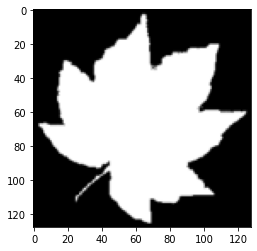

In [249]:
# train_ds[0][0]
plt.imshow(img_tensor.permute(1,2,0))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0431, 0.2784, 0.4039, 0.7333, 0.8235, 0.8235, 0.8235, 0.8235,
        0.8235, 0.8235, 0.8667, 0.9216, 0.8314, 0.8235, 0.8235, 0.8941, 0.9882,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9882, 0.9333, 0.7059, 0.4824, 0.1765, 0.0118, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0863, 0.7843, 0.6118, 0.0235,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.2235,
        0.6941, 0.9922, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9451, 0.3961, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

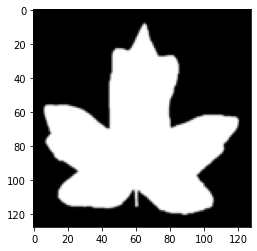

In [250]:
# plt.imshow(train_ds[0][0].permute(1,2,0))
img = valid_ds[0][0]
print(img[0][115])
plt.imshow(img.permute(1,2,0))

In [251]:
# torch.mean(img_tensor), torch.mean(valid_ds[0][0])

In [255]:
predict_image(img_tensor, model2)

tensor([33])


tensor([[-401.9730, -403.6779, -404.0326, -401.8599, -405.3939, -407.2168,
         -409.5945, -404.8673, -403.2292, -406.1447, -408.3864, -404.7146,
         -403.9341, -412.2189, -404.9093, -405.6760, -406.1674, -405.8642,
         -411.1371, -406.8222, -405.8706, -405.5556, -407.1365, -409.3708,
         -407.6463, -406.6205, -409.8607, -405.9088, -406.0441, -401.9883,
         -402.2210, -404.6159, -405.7289, -400.6080, -407.6169, -409.5135,
         -406.3997, -406.4103, -408.2722, -405.3252, -407.2597, -408.9162,
         -404.4779, -407.9434, -403.7420, -405.7701, -406.2076, -402.6366,
         -404.2089, -403.6128, -412.0452, -402.8636, -406.5209, -404.7474,
         -404.8482, -406.2445, -402.9042, -401.9710, -405.7935, -405.9708,
         -409.3943, -404.8451, -404.3988, -407.5647, -407.9011, -411.1724,
         -403.7157, -403.4909, -407.5209, -403.6034, -405.6011, -406.6454,
         -407.1868, -406.0564, -405.7559, -405.9560, -405.9785, -407.4062,
         -405.2921, -404.

torch.Size([3, 128, 128])


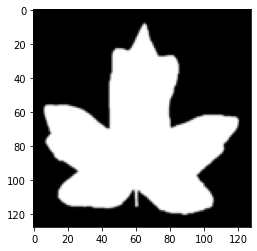

In [256]:
img, label = valid_ds[0]
plt.imshow(img.permute(1,2,0))
print(img.shape)

In [222]:
val_img, label = valid_ds[8]
label

2

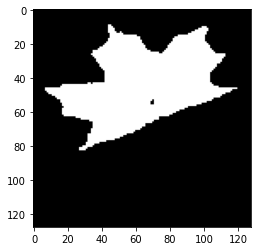

In [80]:
plt.imshow(img_tensor.permute(1,2,0))

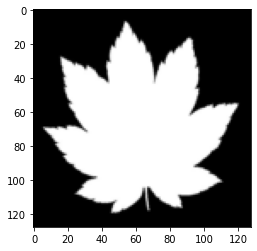

In [74]:
plt.imshow(val_img.permute(1,2,0))

In [61]:
val_img.shape, label

(torch.Size([3, 128, 128]), 0)

In [ ]:
type(val_img)

torch.Tensor

In [225]:
predict_image(val_img, model2)

tensor([2])


tensor([[-387.1309, -395.5060, -385.0825, -388.8207, -392.0958, -395.4164,
         -393.9241, -394.3451, -389.8334, -388.1223, -397.5246, -393.5572,
         -389.8031, -395.0933, -392.2997, -391.4854, -393.4868, -391.2674,
         -394.1221, -391.6335, -394.1869, -394.2039, -394.6821, -393.3562,
         -394.8069, -393.2772, -400.3936, -395.6362, -395.6169, -391.6427,
         -390.7158, -392.0942, -391.8263, -394.7493, -396.8214, -392.0613,
         -397.4904, -395.4505, -395.1997, -398.9175, -393.8214, -392.2409,
         -393.2225, -395.0144, -392.8076, -390.2342, -394.8613, -388.2989,
         -390.9156, -392.3740, -390.9484, -389.4706, -395.4377, -389.9356,
         -393.0888, -392.7470, -389.4032, -394.5698, -390.3473, -391.1375,
         -397.6027, -394.3820, -391.3206, -394.3756, -399.8839, -396.6736,
         -390.3804, -389.9344, -391.9463, -393.2135, -388.3656, -394.5247,
         -402.6900, -391.5317, -392.4506, -391.3136, -394.6823, -394.4934,
         -387.5881, -393.